In [2]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pers_experiments = "(hostname == 'scyper22' or hostname == 'scyper21')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton", "stinger7-ref", "teseo-lcc.12"]
#libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "sortledton", "teseo-lcc.12", "llama8-ref"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

scaling_graphs="graph == 'graph500-24'"


## Memory consumption

In [4]:
memory_consumption_data = common.import_gfe("view_updates_memory_footprint").query(pers_experiments)
memory_consumption_data["memory_usage_gb"] = memory_consumption_data["memory_usage_bytes"] / 1e9
memory_consumption_data["progress"] = memory_consumption_data["progress"].round(2)

rename_libraries = {
    "csr3": "CSR",
    "sortledton": "Sortledton",
    "llama8-ref": "LLama",
    "csr3-lcc": "CSR-LCC",
    "g1_v6-ref-ignore-build": "G1",
    "livegraph3_ro": "Livegraph",
    "stinger7-ref": "Stinger",
    "teseo-lcc.12": "Teseo",
    "teseo-lcc-dv.12b": "Teseo dense"
}

memory_consumption_data["library"] = memory_consumption_data["library"].map(lambda l: rename_libraries[l] if l in rename_libraries  else l)

#memory_consumption_data = memory_consumption_data[memory_consumption_data["library"] == "sortledton"]
grouped = memory_consumption_data.groupby(["graph", "library", "exec_id"]).agg(m=("memory_usage_gb", "max"))
grouped

m
graph       library    exec_id            
graph500-24 G1         16550     37.821400
            LLama      16427    209.541899
                       16532    210.416847
                       16535    209.615561
            Livegraph  16549    214.550812
            Sortledton 16544     18.229719
            Stinger    16547     27.888060
            Teseo      16545     48.430625
uniform-24  G1         16556    106.681984
            LLama      16555    223.559187
            Livegraph  16554    206.808074
            Sortledton 16557     21.074117
            Stinger    16553     29.363470
            Teseo      16552     46.507296

In [5]:
memory_consumption_data_uniform = memory_consumption_data.query("graph == 'uniform-24'")
memory_consumption_pivot = memory_consumption_data_uniform.pivot_table(values="memory_usage_gb", columns="library", index="progress")
memory_consumption_pivot.interpolate(method="index", inplace=True, limit=4)

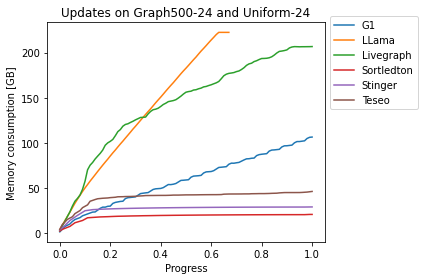

In [9]:
path = os.environ["HOME"] + "/workspace/sortledton-presentation/figures/memory_consumption_uniform.png"

p = memory_consumption_pivot.plot.line()
p.legend(bbox_to_anchor=(1.0, 1.05))
plt.xlabel("Progress")
plt.ylabel("Memory consumption [GB]")
plt.title("Updates on Graph500-24 and Uniform-24")
plt.tight_layout()
plt.savefig(path)

### Comparision unifrom vs graph500
The memory consumption trends and ranking is equal for both graphs. In the paper, we show only graph500.

## Throughput

In [9]:
throughput_data = common.import_gfe("view_updates_throughput").query(pers_experiments)
throughput_data["minute"] = (throughput_data["second"] / 60).round(1)

In [23]:
pivot_throughput_data_graph500 = throughput_data.query("graph == 'graph500-24'").pivot_table(index="minute", columns="library", values="throughput")
pivot_throughput_data_uniform = throughput_data.query("graph == 'uniform-24'").pivot_table(index="minute", columns="library", values="throughput")

<AxesSubplot:xlabel='Time [minutes]', ylabel='Throughput [eps]'>

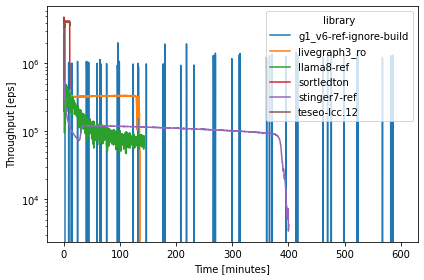

In [24]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/throughput.png"


p = pivot_throughput_data_graph500.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
#p.legend(bbox_to_anchor=(1.0, 1.05))

plt.xlabel("Time [minutes]")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(path)

p

<AxesSubplot:xlabel='Time [minutes]', ylabel='Throughput [eps]'>

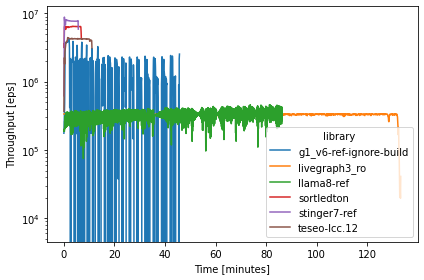

In [29]:
path = os.environ["HOME"] + "/workspace/sortledton/src/figures/throughput_uniform.png"


p = pivot_throughput_data_uniform.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
#p.legend(bbox_to_anchor=(1.0, 1.05))

plt.xlabel("Time [minutes]")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(path)

p

### Throughput explanation

#### Graph500 vs uniform

We see equal tendencies as for inserts only: most systems are faster to varying degree for uniform graphs, the ranking is similar to inserts only (stringer, sortledton, teseo, graphone, llama, livegraph). 

We see equal tendencies as for graph500 in the throughput over time but to lesser degree. We show only the graph500 in the paper.

#### General
All graphs drop to a very low value in the end, as only a few threads run the last updates of the experiment. 
We remove that drop for the paper in the end.

#### Stinger

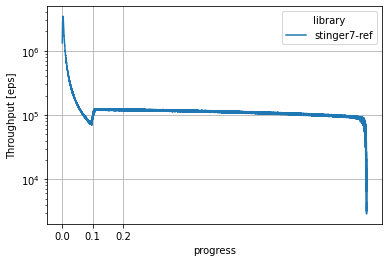

In [28]:
temp = throughput_data.query("graph == 'graph500-24'").query("library == 'stinger7-ref'")
pivot_throughput_data_on_progress = temp.pivot_table(index="progress", columns="library", values="throughput")

p = pivot_throughput_data_on_progress.plot.line()

p.set_yscale('log')
plt.ylabel("Throughput [eps]")
plt.xticks([0.0, 0.1, 0.2])
plt.grid()

We see that Stinger throughput drops from 0.0 to 0.1 percent of progress to stabilize after at a slighly higher values. 

At 0.1 progress the graph reached its maximum size. After deletions and insertions balance each other. 

Until 0.1 progress, Stinger needs to allocate new blocks and the data structure grows. Additional memory pressure and exponentially growing adjacency sets (hub vertices) lead to decreasing throughput. 

After 0.1 progress, all updates and deletes are in place for Stinger. We see slightly higher and stable througput.

#### LLAMA

For LLAMA, we observe slowly decreasing throughput. Also, the throughput is unstable and varies by roughly 100k edges per second.

LLAMA creates a new snapshot every 10 seconds. Since, they do not implement any garbage collection, memory pressure increases and their throughput sinks - see also plot of memory usage.

The througput varies because they cannot create a snapshot while inserting vertices. 


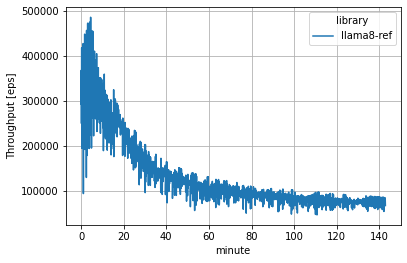

In [26]:
temp = throughput_data.query("graph == 'graph500-24'").query("library=='llama8-ref'")
pivot_llama = temp.pivot_table(index="minute", columns="library", values="throughput")

p = pivot_llama.plot.line()
plt.ylabel("Throughput [eps]")
plt.grid()